In [15]:
############################################################
# Author: Claretta Portu
# Course: Programming
# Project: Personal Finance Analysis
# Description: Load, clean, analyze expenses and save outputs
############################################################

In [16]:
############################################################
# Import required libraries
# pandas: used to load and manipulate tabular data
# matplotlib: used to create plots for the analysis
# pathlib: used to manage file paths in a safe cross-platform way
############################################################

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [17]:
############################################################
# Define project paths and create outputs folders
# This ensures the notebook always finds the CSV file in /data
# and saves results in /outputs (tables and charts)
############################################################

BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
OUTPUTS_DIR = BASE_DIR / "outputs"
TABLES_DIR = OUTPUTS_DIR / "tables"
FIGURES_DIR = OUTPUTS_DIR / "figures"

# Create the output folders if they do not already exist
TABLES_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Print paths for confirmation and debugging
print("Project folder:", BASE_DIR)
print("Data folder:", DATA_DIR)
print("Outputs folder:", OUTPUTS_DIR)

Project folder: /Users/clarettaportu/Desktop/Programming - Personal Finance Tool
Data folder: /Users/clarettaportu/Desktop/Programming - Personal Finance Tool/data
Outputs folder: /Users/clarettaportu/Desktop/Programming - Personal Finance Tool/outputs


In [18]:
############################################################
# Load expense data from CSV file
# This cell checks if the file exists and then reads it into a DataFrame
############################################################

csv_path = DATA_DIR / "expenses_sample.csv"

# Stop execution early with a clear message if the file is missing
if not csv_path.exists():
    raise FileNotFoundError(
        f"Cannot find: {csv_path}\n"
        "Check that expenses_sample.csv is inside the data folder."
    )

# Read the CSV file into a pandas DataFrame
df_raw = pd.read_csv(csv_path)

# Display the first rows to confirm successful loading
df_raw.head()

,date,description,category,amount
0,2025-01-02,Coffee,Food,3.50
1,2025-01-03,Bus ticket,Transport,2.75
2,2025-01-04,Groceries,Food,45.20
3,2025-01-06,Lunch,Food,9.80
4,2025-01-07,Gas,Transport,40.00


In [19]:
############################################################
# Inspect dataset structure and missing values
# This cell helps understand the dataset before cleaning it
############################################################

# Print basic information about the dataset size and columns
print("Shape:", df_raw.shape)
print("\nColumns:", list(df_raw.columns))

# Count missing values in each column to identify potential issues
print("\nMissing values:\n", df_raw.isna().sum())

# Show data types and non-null counts for each column
df_raw.info()

Shape: (90, 4)

Columns: ['date', 'description', 'category', 'amount']

Missing values:
 date           0
description    0
category       0
amount         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         90 non-null     object 
 1   description  90 non-null     object 
 2   category     90 non-null     object 
 3   amount       90 non-null     float64
dtypes: float64(1), object(3)
memory usage: 2.9+ KB


In [20]:
############################################################
# Clean dataset: fix types, remove invalid rows, sort by date
# Main goal: ensure date and amount are valid and remove incomplete entries
############################################################

# Create a working copy so the original raw dataset stays unchanged
df = df_raw.copy()

# Convert date column to datetime format (invalid dates become NaT)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Convert amount column to numeric values (invalid numbers become NaN)
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")

# Clean text fields: remove extra spaces and standardize category naming
df["description"] = df["description"].astype(str).str.strip()
df["category"] = df["category"].astype(str).str.strip().str.title()

# Remove rows where essential fields are missing after conversion
df = df.dropna(subset=["date", "category", "amount"])

# Keep only positive expenses (remove refunds/invalid zero or negative rows)
df = df[df["amount"] > 0]

# Remove duplicated transactions if any exist
df = df.drop_duplicates()

# Sort transactions chronologically for cleaner analysis
df = df.sort_values("date").reset_index(drop=True)

# Preview cleaned dataset
df.head()

,date,description,category,amount
0,2025-01-02,Coffee,Food,3.50
1,2025-01-03,Bus ticket,Transport,2.75
2,2025-01-04,Groceries,Food,45.20
3,2025-01-06,Lunch,Food,9.80
4,2025-01-07,Gas,Transport,40.00


In [21]:
############################################################
# Compute key summaries: total, by category, by month
############################################################

# Create a year-month column for monthly grouping (e.g., 2025-01)
df["year_month"] = df["date"].dt.to_period("M").astype(str)

# Calculate total amount spent across all transactions
total_spent = round(df["amount"].sum(), 2)

# Group by category to calculate total spend per category
summary_by_category = (
    df.groupby("category", as_index=False)["amount"]
      .sum()
      .rename(columns={"amount": "total_spent"})
      .sort_values("total_spent", ascending=False)
      .reset_index(drop=True)
)

# Group by year_month to calculate total spend per month
summary_by_month = (
    df.groupby("year_month", as_index=False)["amount"]
      .sum()
      .rename(columns={"amount": "total_spent"})
      .sort_values("year_month")
      .reset_index(drop=True)
)

# Print total spent and preview both summary tables
print("Total spent:", total_spent)
summary_by_category.head(), summary_by_month.head()

Total spent: 6271.4


(        category  total_spent
 0           Rent      3900.00
 1           Food       696.80
 2      Utilities       486.14
 3  Entertainment       460.36
 4         Health       376.50,
   year_month  total_spent
 0    2025-01       986.03
 1    2025-02      1043.64
 2    2025-03      1053.58
 3    2025-04      1053.53
 4    2025-05      1047.98)

In [22]:
############################################################
# Descriptive statistics of expense amounts
# This provides mean, standard deviation, min/max and quartiles
############################################################

# Generate descriptive statistics for the amount column
amount_stats = df["amount"].describe().round(2)

# Display statistics
amount_stats

count     90.00
mean      69.68
std      157.06
min        2.75
25%       11.62
50%       29.99
75%       49.42
max      650.00
Name: amount, dtype: float64

In [23]:
############################################################
# Percentage contribution of each category
# This shows how much each category contributes to total spending
############################################################

# Copy category summary to avoid modifying the original table
category_percentage = summary_by_category.copy()

# Calculate category percentage share of total spending
category_percentage["percentage"] = (
    category_percentage["total_spent"] / category_percentage["total_spent"].sum() * 100
).round(2)

# Display category shares
category_percentage

,category,total_spent,percentage
0,Rent,3900.00,62.19
1,Food,696.80,11.11
2,Utilities,486.14,7.75
3,Entertainment,460.36,7.34
4,Health,376.50,6.00
5,Transport,351.60,5.61


In [24]:
############################################################
# Identify highest and lowest single expenses
# Useful to quickly detect outliers or major spending events
############################################################

# Find the transaction with the maximum amount
highest_expense = df.loc[df["amount"].idxmax()]

# Find the transaction with the minimum amount
lowest_expense = df.loc[df["amount"].idxmin()]

# Display both results
highest_expense, lowest_expense

(date           2025-01-30 00:00:00
 description                   Rent
 category                      Rent
 amount                       650.0
 year_month                 2025-01
 Name: 14, dtype: object,
 date           2025-01-03 00:00:00
 description             Bus ticket
 category                 Transport
 amount                        2.75
 year_month                 2025-01
 Name: 1, dtype: object)

In [25]:
############################################################
# Average expense per category
# This helps distinguish frequent small expenses vs large occasional expenses
############################################################

# Group by category and compute the mean transaction amount
avg_by_category = (
    df.groupby("category", as_index=False)["amount"]
      .mean()
      .rename(columns={"amount": "average_spent"})
      .round(2)
      .sort_values("average_spent", ascending=False)
)

# Display results
avg_by_category

,category,average_spent
3,Rent,650.00
5,Utilities,40.51
2,Health,34.23
4,Transport,27.05
0,Entertainment,25.58
1,Food,23.23


In [26]:
############################################################
# Number of transactions per category
# This shows how often each category occurs in the dataset
############################################################

# Count number of rows per category (each row is one transaction)
transactions_by_category = (
    df.groupby("category", as_index=False)["amount"]
      .count()
      .rename(columns={"amount": "num_transactions"})
      .sort_values("num_transactions", ascending=False)
)

# Display transaction counts
transactions_by_category

,category,num_transactions
1,Food,30
0,Entertainment,18
4,Transport,13
5,Utilities,12
2,Health,11
3,Rent,6


In [27]:
############################################################
# Save cleaned data and analysis tables to outputs/tables
############################################################

# Save cleaned dataset for future analysis steps
df.to_csv(TABLES_DIR / "expenses_cleaned.csv", index=False)

# Save main summaries
summary_by_category.to_csv(TABLES_DIR / "summary_by_category.csv", index=False)
summary_by_month.to_csv(TABLES_DIR / "summary_by_month.csv", index=False)

# Save extra analysis tables
amount_stats.to_csv(TABLES_DIR / "amount_statistics.csv")
avg_by_category.to_csv(TABLES_DIR / "average_by_category.csv", index=False)
transactions_by_category.to_csv(TABLES_DIR / "transactions_by_category.csv", index=False)
category_percentage.to_csv(TABLES_DIR / "category_percentage.csv", index=False)

# Confirm where files were saved
print("Saved tables in:", TABLES_DIR)

Saved tables in: /Users/clarettaportu/Desktop/Programming - Personal Finance Tool/outputs/tables


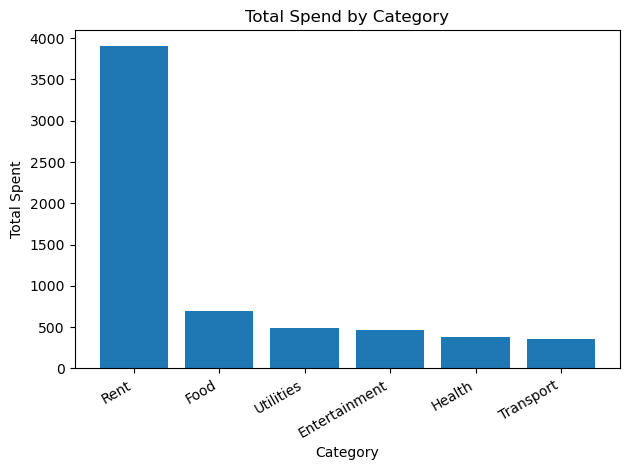

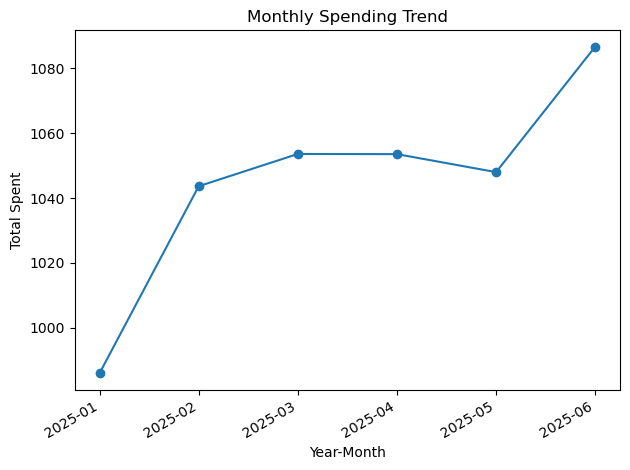

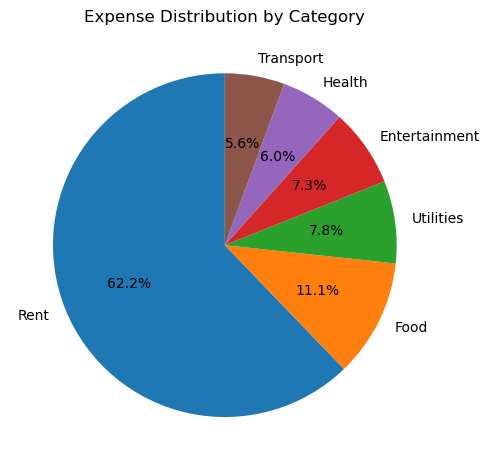

Saved figures in: /Users/clarettaportu/Desktop/Programming - Personal Finance Tool/outputs/figures


In [28]:
############################################################
# Create and save charts to outputs/figures
# Visual outputs help communicate findings clearly in the final report
############################################################

# Bar chart: total spending by category
plt.figure()
plt.bar(summary_by_category["category"], summary_by_category["total_spent"])
plt.title("Total Spend by Category")
plt.xlabel("Category")
plt.ylabel("Total Spent")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "spend_by_category.png", dpi=150)
plt.show()

# Line chart: monthly trend of total spending
plt.figure()
plt.plot(summary_by_month["year_month"], summary_by_month["total_spent"], marker="o")
plt.title("Monthly Spending Trend")
plt.xlabel("Year-Month")
plt.ylabel("Total Spent")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "spend_by_month.png", dpi=150)
plt.show()

# Pie chart: share of spending by category
plt.figure()
plt.pie(
    category_percentage["percentage"],
    labels=category_percentage["category"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Expense Distribution by Category")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "expense_distribution_pie.png", dpi=150)
plt.show()

# Confirm where figures were saved
print("Saved figures in:", FIGURES_DIR)